In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
import sys
import pathlib
import pickle
import warnings

sys.path.append('..')

In [4]:
import pandas as pd
from loguru import logger
import seaborn as sns

In [5]:
from pals.pimp_tools import get_pimp_API_token_from_env, PIMP_HOST, download_from_pimp
from pals.noise import construct_intensity_df, add_random_peaks, plot_intensity_matrix, convert_to_data_source
from pals.evaluation import run_noise_experiment, calc_av_p_scores, construct_single_box_df, _compute_prec_rec_f1, _select_significant_entries, get_tp_fn_fn, adjust_box_widths, get_auc
from pals.feature_extraction import DataSource

from pals.PALS import PALS
from pals.ORA import ORA
from pals.GSEA import GSEA
from pals.common import *

2020-01-27 15:40:54.492 | WARNING  | pals.reactome:get_neo4j_driver:14 - Using a default neo4j server: bolt://localhost:7687
2020-01-27 15:40:54.493 | WARNING  | pals.reactome:get_neo4j_driver:19 - Using a default neo4j username or password: neo4j
2020-01-27 15:40:55.562 | INFO     | pals.reactome:get_neo4j_driver:24 - Created graph database driver for bolt://localhost:7687 (neo4j)


## Synthetic data test

In [13]:
control_fnames = ['Control_1.mzXML', 'Control_2.mzXML', 'Control_3.mzXML', 'Control_4.mzXML']
case_fnames = ['Case_1.mzXML', 'Case_2.mzXML', 'Case_3.mzXML', 'Case_4.mzXML']
pathway_names ={'two':2, 'four':4, 'six':6, 'ten':10, 'twenty':20, 'forty':40, 'eighty':80}
sample_fnames = control_fnames + case_fnames
true_answers = set(pathway_names.keys())

bg_pw = 100
min_replace = 5000
prob_missing_peaks = 0.2

base_dir = os.path.join('test_data', 'synthetic')
create_if_not_exist(base_dir)

In [7]:
int_df, updated_pathway_names = construct_intensity_df(sample_fnames, pathway_names, random=False, background_pathways=bg_pw)
print(int_df.shape)
print(updated_pathway_names)

(2940, 8)
{'two': 2, 'four': 4, 'six': 6, 'ten': 10, 'twenty': 20, 'forty': 40, 'eighty': 80, 'background0': 45, 'background1': 38, 'background2': 10, 'background3': 13, 'background4': 18, 'background5': 37, 'background6': 30, 'background7': 18, 'background8': 36, 'background9': 33, 'background10': 49, 'background11': 35, 'background12': 47, 'background13': 44, 'background14': 9, 'background15': 47, 'background16': 32, 'background17': 40, 'background18': 24, 'background19': 8, 'background20': 11, 'background21': 31, 'background22': 37, 'background23': 37, 'background24': 33, 'background25': 44, 'background26': 7, 'background27': 14, 'background28': 42, 'background29': 42, 'background30': 35, 'background31': 38, 'background32': 38, 'background33': 24, 'background34': 17, 'background35': 30, 'background36': 43, 'background37': 5, 'background38': 24, 'background39': 48, 'background40': 43, 'background41': 20, 'background42': 44, 'background43': 28, 'background44': 14, 'background45': 47, 

(3345, 8)


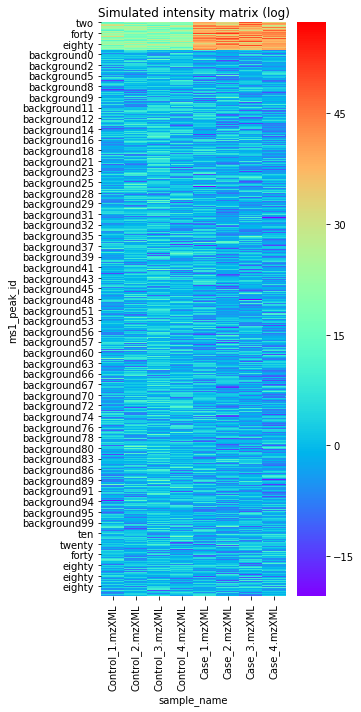

In [8]:
percent = 250
noise_mean = 0
noise_std = 5
int_df = add_random_peaks(sample_fnames, pathway_names, int_df, percent, noise_mean, noise_std)
print(int_df.shape)
plot_intensity_matrix(int_df)

In [9]:
ds = convert_to_data_source(int_df, updated_pathway_names, case_fnames, control_fnames, prob_missing_peaks, min_replace)

2020-01-27 15:40:56.978 | DEBUG    | pals.noise:convert_to_data_source:111 - Dataset annotations = 3345
2020-01-27 15:40:56.979 | DEBUG    | pals.noise:convert_to_data_source:115 - Sampled annotations = 2676 with prob_missing_peaks=0.20
2020-01-27 15:40:56.980 | DEBUG    | pals.feature_extraction:__init__:47 - Using user-provided database
2020-01-27 15:40:56.980 | DEBUG    | pals.feature_extraction:__init__:55 - Mapping pathway to unique ids
2020-01-27 15:40:56.982 | DEBUG    | pals.feature_extraction:__init__:69 - Creating dataset to pathway mapping
2020-01-27 15:40:57.147 | DEBUG    | pals.feature_extraction:__init__:97 - Computing unique id counts


### Grid search over PALS plage and hg parameters

In this section, we compare the difference in pathway ranking due to varying the PLAGE and Hypergeometric parameters.

In [14]:
plage_weight = 5
hg_weight = 1

In [20]:
significant_column = 'case/control comb_p'
pals_plage_weights = np.array(range(1, 11))
pals_hg_weights = np.array(range(1, 11))
pals_num_resamples = 1000
pals_resample = True if pals_num_resamples > 0 else False
threshold = SIGNIFICANT_THRESHOLD

In [16]:
set_log_level_info() # don't print too many debug messages during experiment

In [18]:
results = []
f1_mat = np.zeros((len(pals_plage_weights), len(pals_hg_weights)))
for i in range(len(pals_plage_weights)):
    pals_plage_weight = pals_plage_weights[i]
    
    for j in range(len(pals_hg_weights)):
        pals_hg_weight = pals_hg_weights[j]
        logger.info('Running PALS with plage_weight=%d hg_weight=%d' % (pals_plage_weight, pals_hg_weight))
        
        # run PALS and select the top-N significant pathways from the results
        pals = PALS(ds, plage_weight=pals_plage_weight, hg_weight=pals_hg_weight, num_resamples=pals_num_resamples)
        df = pals.get_pathway_df(resample=pals_resample)
        filtered_df = _select_significant_entries(df, significant_column, threshold, None)
        TP, FP, FN, prec, rec, f1 = _compute_prec_rec_f1(true_answers, set(filtered_df.index.values))
        row = [pals_plage_weight, pals_hg_weight, TP, FP, FN, prec, rec, f1]
        results.append(row)
        
        f1_mat[i, j] = f1
        
results_df = pd.DataFrame(results, columns=['plage_weight', 'hg_weight', 'TP', 'FP', 'FN', 'prec', 'rec', 'F1'])

2020-01-27 15:47:32.731 | INFO     | __main__:<module>:8 - Running PALS with plage_weight=1 hg_weight=1
2020-01-27 15:47:34.109 | INFO     | __main__:<module>:8 - Running PALS with plage_weight=1 hg_weight=2
2020-01-27 15:47:35.513 | INFO     | __main__:<module>:8 - Running PALS with plage_weight=1 hg_weight=3
2020-01-27 15:47:36.947 | INFO     | __main__:<module>:8 - Running PALS with plage_weight=1 hg_weight=4
2020-01-27 15:47:38.396 | INFO     | __main__:<module>:8 - Running PALS with plage_weight=1 hg_weight=5
2020-01-27 15:47:39.843 | INFO     | __main__:<module>:8 - Running PALS with plage_weight=1 hg_weight=6
2020-01-27 15:47:41.239 | INFO     | __main__:<module>:8 - Running PALS with plage_weight=1 hg_weight=7
2020-01-27 15:47:42.659 | INFO     | __main__:<module>:8 - Running PALS with plage_weight=1 hg_weight=8
2020-01-27 15:47:44.061 | INFO     | __main__:<module>:8 - Running PALS with plage_weight=1 hg_weight=9
2020-01-27 15:47:45.511 | INFO     | __main__:<module>:8 - Runni

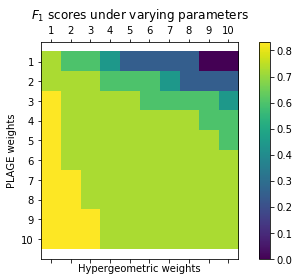

In [21]:
fig, ax = plt.subplots(1, 1)
img = ax.matshow(f1_mat)
ax.set_xticks(pals_hg_weights-1)
ax.set_xticklabels(pals_hg_weights)
ax.set_xlabel('Hypergeometric weights')
ax.set_yticks(pals_plage_weights-1)
ax.set_yticklabels(pals_plage_weights)
ax.set_ylabel('PLAGE weights')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

fig.colorbar(img)
plt.title('$F_{1}$ scores under varying parameters', y=1.08)
plt.tight_layout()

plt.savefig(os.path.join('test_data', 'HAT', 'f1_grid_search.eps'), dpi=300)